# LAB 1

In [38]:
import datetime
import requests
import pandas as pd
import hopsworks
import datetime
from pathlib import Path
from functions import util
import json
import re
import os
import warnings
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings("ignore")

## 1.Backfill feature pipeline

Write a backfill feature pipeline that downloads historical weather data (ideally >1
year of data), loads a csv file with historical air quality data (downloaded from
https://aqicn.org) and registers them as 2 Feature Groups with Hopsworks.

### 1.1 Import air quality data on 5 years at Stockholm

In [5]:
air_quality_df = pd.read_csv("../../data/stockholm-hornsgatan 108 gata-air-quality.csv")

air_quality_df['date'] = pd.to_datetime(air_quality_df['date'], format='%Y/%m/%d')

# Handle non-numeric values in 'pm25' and 'pm10', replace them with NaN
air_quality_df['pm25'] = pd.to_numeric(air_quality_df['pm25'], errors='coerce')
air_quality_df['pm10'] = pd.to_numeric(air_quality_df['pm10'], errors='coerce')

# Fill NaN values with 0 (or use mean or another method depending on your choice)
air_quality_df['pm25'].fillna(0, inplace=True)
air_quality_df['pm10'].fillna(0, inplace=True)

# Convert 'pm25' and 'pm10' columns to integers
air_quality_df['pm25'] = air_quality_df['pm25'].astype(int)
air_quality_df['pm10'] = air_quality_df['pm10'].astype(int)


air_quality_df = air_quality_df.drop(columns=['no2'])


air_quality_df.head()

,date,pm25,pm10
0,2024-11-01,8,3
1,2024-11-02,5,3
2,2024-11-03,6,6
3,2024-11-04,7,4
4,2024-11-05,11,6


### 1.2 Import weather data on one year at Stockholm

In [45]:
import requests
import pandas as pd
import json
from datetime import datetime, timedelta

# Coordinates of Stockholm and date range for historical data
latitude = 59.3293
longitude = 18.0686
today = datetime.today().date()
start_date = today - timedelta(days=365)
end_date = today - timedelta(days=2)

country="sweden"
city = "stockholm"
street = "stockholm-hornsgatan-108"
aqicn_url="https://api.waqi.info/feed/@10009"

earliest_aq_date = pd.Series.min(air_quality_df['date'])
earliest_aq_date = earliest_aq_date.strftime('%Y-%m-%d')

# Calculate daily average temperature
df_weather = util.get_historical_weather(city, earliest_aq_date, str(today), latitude, longitude)

# Print the result
df_weather = df_weather.drop(columns='city')

df_weather



Coordinates 59.29701232910156°N 18.163265228271484°E
Elevation 24.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


,date,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2017-10-03,14.615000,10.214999,0.500000,18.391737,209.271942
1,2017-10-04,13.565000,7.415000,2.900000,22.206486,248.656326
2,2017-10-05,11.014999,5.965000,2.600000,16.595179,306.521240
3,2017-10-06,11.165000,6.215000,0.500000,23.871555,320.408325
4,2017-10-07,8.815000,4.215000,6.300001,14.332341,343.018829
...,...,...,...,...,...,...
2594,2024-11-09,7.365000,4.665000,0.000000,14.428097,257.365479
2595,2024-11-10,7.065000,4.415000,0.100000,9.292255,145.380463
2596,2024-11-11,5.665000,3.615000,1.100000,9.676569,234.773972
2597,2024-11-12,4.965000,1.315000,0.000000,10.990322,288.903290


### 1.3 Connection to hopsworks

In [3]:
import hopsworks

with open('../../data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

In [4]:


project = hopsworks.login(project="ID2223LAB1KTH")
fs = project.get_feature_store()


Connected. Call `.close()` to terminate connection gracefully.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1170583
Connected. Call `.close()` to terminate connection gracefully.


In [67]:
# Create a weather data feature group
weather_fg = fs.create_feature_group(
    name="stockholm_weather",
    version=1,
    description="Weather data for Stockholm including temperature, humidity, wind speed, and wind direction",
    primary_key=["date"],  
    event_time="date" 
)


weather_fg.insert(df_weather)

print("Weather feature group created and data inserted successfully.")


RestAPIError: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/1170583/featurestores/1161286/featuregroups). Server response: 
HTTP code: 400, HTTP reason: Bad Request, body: b'{"errorCode":270089,"usrMsg":"project: ID2223LAB1KTH, featurestoreId: 1161286","errorMsg":"The feature group you are trying to create does already exist."}', error code: 270089, error msg: The feature group you are trying to create does already exist., user msg: project: ID2223LAB1KTH, featurestoreId: 1161286

In [ ]:

air_quality_fg = fs.create_feature_group(
    name="stockholm_air_quality",
    version=1,
    description="Air quality data for Stockholm with PM2.5 concentrations",
    primary_key=["date"],  # 'time' column as the primary key
    event_time="date"      # Specify 'time' as the event time
)


air_quality_fg.insert(air_quality_df)

print("Air quality feature group created and data inserted successfully.")


Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1170583/fs/1161286/fg/1347959


Uploading Dataframe: 0.00% |          | Rows 0/2557 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: stockholm_air_quality_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1170583/jobs/named/stockholm_air_quality_1_offline_fg_materialization/executions
Air quality feature group created and data inserted successfully.


## 2. Schedule a daily feature pipeline

In .github/workflows

## 3.Write a training pipeline

### 3.1 Getting datas from features groups

In [ ]:
# Load the Feature Groups for air quality and weather data
air_quality_fg = fs.get_feature_group(name="stockholm_air_quality", version=1)
weather_fg = fs.get_feature_group(name="stockholm_weather", version=1)

# Read the data from both feature groups
air_quality_df = air_quality_fg.read()
weather_df = weather_fg.read()

# Merge the two feature groups on the 'time' column
merged_df = air_quality_df.merge(weather_df, on="date", how="inner")

# Select features and target for training
features = merged_df[['temperature_2m_max','temperature_2m_min','precipitation_sum','wind_speed_10m_max','wind_direction_10m_dominant']]
target = merged_df['pm25']

merged_df



Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.45s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.80s) 


### 3.2 Create a query

In [33]:
selected_features = air_quality_fg.select(['date','pm25']).join(weather_fg.select_all(), on = ['date'])
selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.81s) 


,date,pm25,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2017-12-01 00:00:00+00:00,12,2.215,-0.085,0.4,20.730501,347.482971
1,2018-01-02 00:00:00+00:00,9,3.765,0.865,0.3,15.546833,226.255768
2,2018-01-10 00:00:00+00:00,38,0.115,-6.435,0.0,10.239453,89.506119
3,2018-02-05 00:00:00+00:00,21,-3.635,-9.585,0.0,13.684735,325.287720
4,2018-03-03 00:00:00+00:00,24,-3.735,-9.185,0.0,10.495713,2.309032
5,2018-03-20 00:00:00+00:00,32,-0.835,-14.885,0.0,21.626984,342.335846
6,2018-03-26 00:00:00+00:00,28,-0.335,-7.335,0.5,17.709658,26.193710
7,2018-04-23 00:00:00+00:00,17,9.365,3.465,2.9,21.434364,167.404770
8,2018-05-09 00:00:00+00:00,29,17.615,8.315,0.0,14.799459,133.503128
9,2018-06-06 00:00:00+00:00,13,16.365,4.465,0.0,17.811815,298.059235


### 3.3 Create a feature view for training

In [13]:
feature_view = fs.create_feature_view(
    name = "air_quality_fv",
    description = "weather features with air quality as the target",
    version = 1,
    labels = ['pm25'],
    query = selected_features
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1170583/fs/1161286/fv/air_quality_fv/version/1


### 3.4 Splitting datas

In [27]:
# order data by dates to find good date to split
dates_ordered = selected_features.read().sort_values(by = 'date').date.reindex()

# define train/test split
train_per = 0.7
train_split = int(dates_ordered.shape[0]*train_per)

# find correct date to split
start_test_date = dates_ordered.iloc[train_split+1]
start_test_date

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.98s) 


Timestamp('2022-10-03 00:00:00+0000', tz='UTC')

In [60]:
dates_ordered.tail()

322    2024-11-16 00:00:00+00:00
805    2024-11-17 00:00:00+00:00
1780   2024-11-18 00:00:00+00:00
1950   2024-11-19 00:00:00+00:00
635    2024-11-20 00:00:00+00:00
Name: date, dtype: datetime64[us, UTC]

In [29]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=start_test_date
)

print(X_train)
X_test

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.50s) 
                           date  temperature_2m_max  temperature_2m_min  \
0     2017-12-01 00:00:00+00:00            2.215000           -0.085000   
1     2018-01-02 00:00:00+00:00            3.765000            0.865000   
2     2018-01-10 00:00:00+00:00            0.115000           -6.435000   
3     2018-02-05 00:00:00+00:00           -3.635000           -9.585000   
4     2018-03-03 00:00:00+00:00           -3.735000           -9.185000   
...                         ...                 ...                 ...   
2509  2022-08-12 00:00:00+00:00           28.665001           14.264999   
2510  2022-08-28 00:00:00+00:00           18.065001           11.565000   
2511  2022-09-06 00:00:00+00:00           19.015001            6.115000   
2512  2022-09-16 00:00:00+00:00           14.464999            7.165000   
2513  2022-10-02 00:00:00+00:00           12.464999            7.915000   

      precipi

,date,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
123,2022-10-20 00:00:00+00:00,8.714999,1.1150,0.0,12.574260,267.310272
124,2022-10-24 00:00:00+00:00,10.115000,6.2150,11.7,19.296135,111.673950
125,2022-11-29 00:00:00+00:00,3.065000,2.1650,3.1,11.841756,111.001190
126,2022-12-09 00:00:00+00:00,-2.835000,-7.0350,1.2,9.449572,331.821503
127,2023-01-03 00:00:00+00:00,0.265000,-5.8850,0.6,18.899143,302.502228
...,...,...,...,...,...,...
2558,2024-10-21 00:00:00+00:00,15.764999,11.1650,0.0,24.738707,219.984772
2559,2024-11-02 00:00:00+00:00,5.365000,2.1650,0.0,26.366159,296.075775
2560,2024-11-08 00:00:00+00:00,8.714999,3.4150,0.0,13.864674,257.650360
2561,2024-11-13 00:00:00+00:00,6.667500,2.0675,0.0,16.559999,237.598511


In [34]:
train_features = X_train.drop(['date'], axis=1)
test_features = X_test.drop(['date'], axis=1)

In [39]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(train_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [40]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 173.200193468369
R squared: -0.17645348392768634


In [41]:
df = y_test
df['predicted_pm25'] = y_pred

In [59]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df = df.iloc[-50:]
df.tail()

,pm25,predicted_pm25,date
633,20,42.303711,2024-11-11 00:00:00+00:00
1625,12,12.889547,2024-11-12 00:00:00+00:00
2561,15,23.603897,2024-11-13 00:00:00+00:00
634,9,16.026558,2024-11-14 00:00:00+00:00
2562,10,19.004604,2024-11-15 00:00:00+00:00


In [57]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

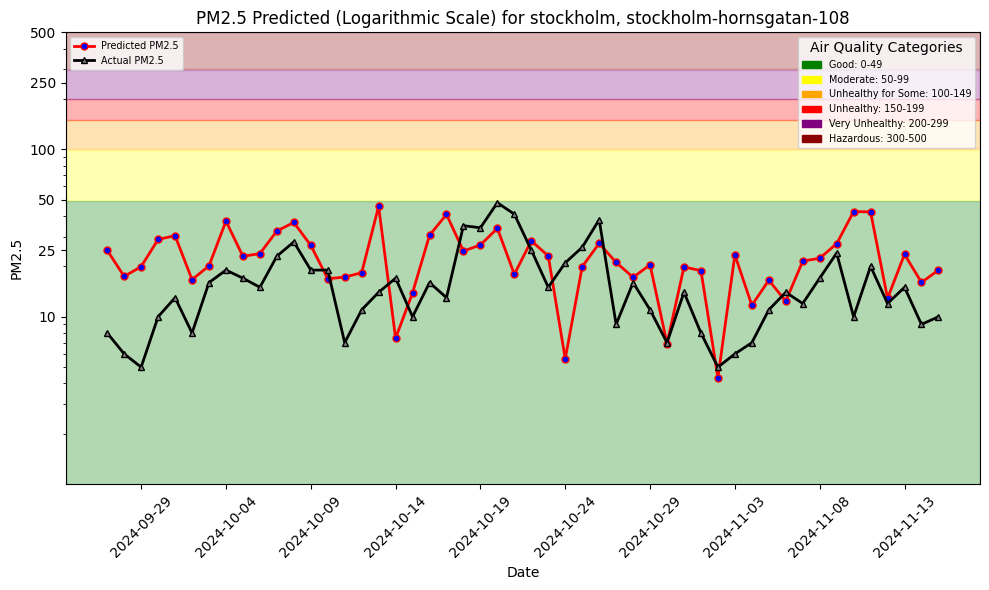

In [58]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()